In [27]:
import sys
sys.path.insert(0, '../../Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import csv

In [28]:
global P_back, rho, u, E, P, x

In [29]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [30]:
def model_init(P_back, x, P, rho, u, E, layers):

    global lb, ub, X, weights, biases, sess
    global P_back_tf, x_tf, P_tf, rho_tf, u_tf, E_tf
    global P_pred, rho_pred, u_pred, E_pred

    X = np.concatenate([P_back, x], 1)

    lb = X.min(0)
    ub = X.max(0)
    
    # Initialize NN
    weights, biases = initialize_NN(layers)        
    
    # tf placeholders and graph
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                 log_device_placement=True))
    
    P_back_tf = tf.placeholder(tf.float32, shape=[None, P_back.shape[1]])
    x_tf = tf.placeholder(tf.float32, shape=[None, x.shape[1]])
    P_tf = tf.placeholder(tf.float32, shape=[None, P.shape[1]])
    rho_tf = tf.placeholder(tf.float32, shape=[None, rho.shape[1]])
    u_tf = tf.placeholder(tf.float32, shape=[None, u.shape[1]])
    E_tf = tf.placeholder(tf.float32, shape=[None, E.shape[1]])
    
    P_pred, rho_pred, u_pred, E_pred, e1, e2, e3, e4 = net_NS(P_back_tf, x_tf, weights, biases)

    # MSE Normalization
    P_norm = np.amax(P)
    rho_norm = np.amax(rho)
    u_norm = np.amax(u)
    E_norm = np.amax(E)
    S_norm = 5.95
    e1_norm = rho_norm*u_norm*S_norm
    e2_norm = P_norm*S_norm
    e3_norm = E_norm*rho_norm*u_norm*S_norm
    a = 40

    global loss
    loss = tf.reduce_sum(tf.square(P_tf - P_pred))/(P_norm**2) + \
                tf.reduce_sum(tf.square(rho_tf - rho_pred))/(rho_norm**2) + \
                tf.reduce_sum(tf.square(u_tf - u_pred))/(u_norm**2) + \
                tf.reduce_sum(tf.square(E_tf - E_pred))/(E_norm**2) + \
                a*tf.reduce_sum(tf.square(e2))/(e2_norm**2) + \
                a*tf.reduce_sum(tf.square(e3))/(e3_norm**2) + \
                a*tf.reduce_sum(tf.square(e1))/(e1_norm**2) + \
                a*tf.reduce_sum(tf.square(e4))/(P_norm**2)
    
    global optimizer
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, 
                                                            method = 'L-BFGS-B', 
                                                            options = {'maxiter': 15000,
                                                                       'maxfun': 15000,
                                                                       'maxcor': 50,
                                                                       'maxls': 50,
                                                                       'ftol' : 1.0 * np.finfo(float).eps})        
    
    optimizer_Adam = tf.train.AdamOptimizer()
    global train_op_Adam
    train_op_Adam = optimizer_Adam.minimize(loss)                    
    
    init = tf.global_variables_initializer()
    sess.run(init)

In [31]:
def initialize_NN(layers):        
    weights = []
    biases = []
    num_layers = len(layers) 
    for l in range(0,num_layers-1):
        W = xavier_init(size=[layers[l], layers[l+1]])
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)        
    return weights, biases

In [32]:
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]        
    xavier_stddev = np.sqrt(2/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

In [33]:
def neural_net(X, weights, biases):
    num_layers = len(weights) + 1
    
    H = 2.0*(X - lb)/(ub - lb) - 1.0
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

In [34]:
def net_NS(P_back, x, weights, biases):
    P_rho_u_E = neural_net(tf.concat([P_back, x], 1), weights, biases)
    P = P_rho_u_E[:,0:1]
    rho = P_rho_u_E[:,1:2]
    u = P_rho_u_E[:,2:3]
    E = P_rho_u_E[:,3:4]

    S = 1 + 2.2*(3*x-1.5)**2
    # autodiff gradient #1
    mass_flow_grad = tf.gradients(rho*u*S, x)[0]
    # autodiff gradient #2
    momentum_grad = tf.gradients((rho*u*u + P)*S, x)[0] - P*tf.gradients(S, x)[0]
    # autodiff gradient #3
    energy_grad = tf.gradients((rho*E + P)*u*S, x)[0]
    # state residual
    gamma = 1.4
    state_res = P - rho*(gamma-1)*(E-0.5*gamma*u*u)

    return P, rho, u, E, mass_flow_grad, momentum_grad, energy_grad, state_res

In [35]:
def callback(loss):
    loss_vector.append(loss)
    print('Loss: %.3e' % (loss))

In [36]:
def train(nIter, P_back, x, rho, u, E, P):

    tf_dict = {P_back_tf: P_back, x_tf: x,
                P_tf: P, rho_tf: rho, u_tf: u, E_tf: E
                }
    
    global loss_vector
    loss_vector = []

    start_time = time.time()
    for it in range(nIter):
        sess.run(train_op_Adam, tf_dict)

        loss_value = sess.run(loss, tf_dict)
        loss_vector.append(loss_value)

        # Print
        if it % 1000 == 0:
            elapsed = time.time() - start_time
            # res1 = self.sess.run(self.e1, tf_dict)
            # res2 = self.sess.run(self.e2, tf_dict)
            # res3 = self.sess.run(self.e3, tf_dict)
            print('Iter: %d, Loss: %.3e, Time: %.2f' % 
                  (it, loss_value, elapsed))
            # print('Mass Residual: %f\t\tMomentum Residual: %f\tEnergy Residual: %f'
            #     %(sum(map(lambda a:a*a,res1))/len(res1), sum(map(lambda a:a*a,res2))/len(res2), sum(map(lambda a:a*a,res3))/len(res3)))
            start_time = time.time()
        
#     optimizer.minimize(sess,
#                         feed_dict = tf_dict,
#                         fetches = [loss],
#                         loss_callback = callback)

    #return loss_vector

In [37]:
def predict(P_back_test, x_test):
    tf_dict = {P_back_tf: P_back_test, x_tf: x_test}
    P_test = sess.run(P_pred, tf_dict)
    rho_test = sess.run(rho_pred, tf_dict)
    u_test = sess.run(u_pred, tf_dict)
    E_test = sess.run(E_pred, tf_dict)
    return P_test, rho_test, u_test, E_test

In [38]:
layers = [2, 10, 10, 10, 4]

In [39]:
P_dataset = []
rho_dataset = []
E_dataset = []
u_dataset = []

with open('cdn_P.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            P_dataset.append(float(element))

with open('cdn_rho.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            rho_dataset.append(float(element))

with open('cdn_E.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            E_dataset.append(float(element))

with open('cdn_u.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            u_dataset.append(float(element))

P_dataset = np.asarray(P_dataset)
rho_dataset = np.asarray(rho_dataset)
E_dataset = np.asarray(E_dataset)
u_dataset = np.asarray(u_dataset)

In [40]:
P_back_train_all = []
P_back_train_all = np.asarray(P_back_train_all)
x_train_all = []
x_train_all = np.asarray(x_train_all)

for i in range(0, 27):
    P_back_value = 0.01*(21+3*i)*np.ones((101,1))
    P_back_train_all = np.concatenate((P_back_train_all, P_back_value), axis=None)
    x_value = 0.01*np.arange(0, 101, dtype=float).flatten()[:,None]
    x_train_all = np.concatenate((x_train_all, x_value), axis=None)

In [41]:
train_frac = 0.01

In [42]:
N_train = int(train_frac*P_dataset.shape[0])

In [43]:
A = np.random.choice(range(P_dataset.shape[0]), size=(N_train,), replace=False)

In [44]:
# x
P_back_train_frac = P_back_train_all[A].flatten()[:,None]
x_train_frac = x_train_all[A].flatten()[:,None]
# y
P_train_frac = P_dataset[A].flatten()[:,None]
rho_train_frac = rho_dataset[A].flatten()[:,None]
u_train_frac = u_dataset[A].flatten()[:,None]
E_train_frac = E_dataset[A].flatten()[:,None]

In [45]:
# Training
model_init(P_back_train_frac, x_train_frac, P_train_frac, rho_train_frac, u_train_frac, E_train_frac, layers)
train(20001, P_back_train_frac, x_train_frac, rho_train_frac, u_train_frac, E_train_frac, P_train_frac)

Iter: 0, Loss: 1.074e+02, Time: 0.76
Iter: 1000, Loss: 9.807e+00, Time: 2.27
Iter: 2000, Loss: 7.337e+00, Time: 2.27
Iter: 3000, Loss: 2.674e+00, Time: 2.40
Iter: 4000, Loss: 1.902e+00, Time: 2.58
Iter: 5000, Loss: 1.380e+00, Time: 2.28
Iter: 6000, Loss: 1.114e+00, Time: 2.29
Iter: 7000, Loss: 9.564e-01, Time: 2.28
Iter: 8000, Loss: 8.627e-01, Time: 2.29
Iter: 9000, Loss: 7.935e-01, Time: 2.28
Iter: 10000, Loss: 7.382e-01, Time: 2.29
Iter: 11000, Loss: 6.881e-01, Time: 2.28
Iter: 12000, Loss: 6.438e-01, Time: 2.27
Iter: 13000, Loss: 6.268e-01, Time: 2.29
Iter: 14000, Loss: 5.624e-01, Time: 2.28
Iter: 15000, Loss: 5.262e-01, Time: 2.28
Iter: 16000, Loss: 4.950e-01, Time: 2.28
Iter: 17000, Loss: 4.681e-01, Time: 2.29
Iter: 18000, Loss: 4.437e-01, Time: 2.46
Iter: 19000, Loss: 4.222e-01, Time: 2.36
Iter: 20000, Loss: 7.686e-01, Time: 2.29


In [46]:
# plt.plot(loss_vector, label='Loss value')
# print("Total Iter = " + str(len(loss_vector)))
# plt.legend()
# plt.title('Loss value over iterations')
# plt.xlabel('#iterations')
# plt.ylabel('Loss')
# plt.show()

In [47]:
# Test Data
P_test_dataset = []
rho_test_dataset = []
E_test_dataset = []
u_test_dataset = []

with open('cdn_P_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            P_test_dataset.append(float(element))

with open('cdn_rho_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            rho_test_dataset.append(float(element))

with open('cdn_E_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            E_test_dataset.append(float(element))

with open('cdn_u_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            u_test_dataset.append(float(element))

P_test_dataset = np.asarray(P_test_dataset).flatten()[:,None]
rho_test_dataset = np.asarray(rho_test_dataset).flatten()[:,None]
E_test_dataset = np.asarray(E_test_dataset).flatten()[:,None]
u_test_dataset = np.asarray(u_test_dataset).flatten()[:,None]

In [48]:
P_back_test=[]
P_back_test=np.asarray(P_back_test)
x_test=[]
x_test=np.asarray(x_test)

for i in range(0, 6):
    P_back_value = 0.01*(35+10*i)*np.ones((101,1))
    P_back_test = np.concatenate((P_back_test, P_back_value), axis=None)
    x_value = 0.01*np.arange(0, 101, dtype=float).flatten()[:,None]
    x_test = np.concatenate((x_test, x_value), axis=None)

P_back_test = P_back_test.flatten()[:,None]
x_test = x_test.flatten()[:,None]

In [49]:
# Prediction
P_test_pred, rho_test_pred, u_test_pred, E_test_pred  = predict(P_back_test, x_test)

In [50]:
# Error
P_test_error = np.linalg.norm(P_test_dataset-P_test_pred,2)/np.linalg.norm(P_test_dataset,2)
print("Test Error in P: "+str(P_test_error))

rho_test_error = np.linalg.norm(rho_test_dataset-rho_test_pred,2)/np.linalg.norm(rho_test_dataset,2)
print("Test Error in rho: "+str(rho_test_error))

u_test_error = np.linalg.norm(u_test_dataset-u_test_pred,2)/np.linalg.norm(u_test_dataset,2)
print("Test Error in u: "+str(u_test_error))

E_test_error = np.linalg.norm(E_test_dataset-E_test_pred,2)/np.linalg.norm(E_test_dataset,2)
print("Test Error in E: "+str(E_test_error))

Test Error in P: 0.10493121902023132
Test Error in rho: 0.09843864382598473
Test Error in u: 0.26020343853847944
Test Error in E: 0.05196033332407061


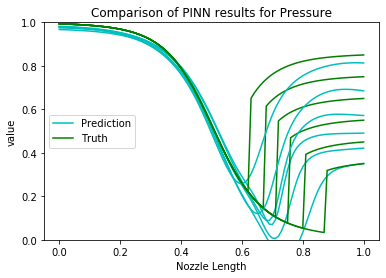

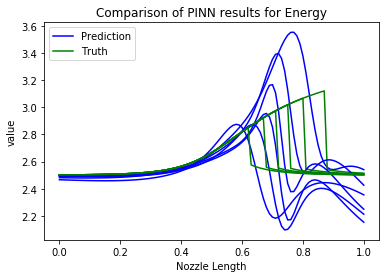

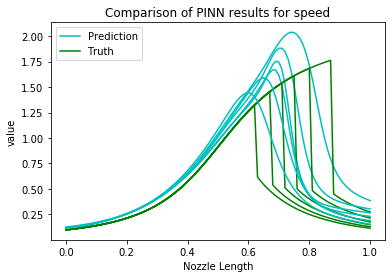

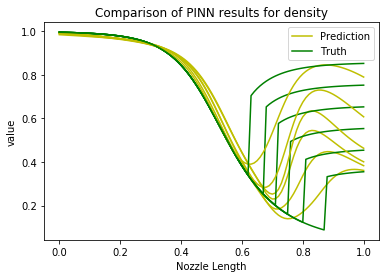

In [51]:
#Plotting
a = 0
b = 6
s = 1
val = 101*a

for i in range (101*a, 101*b, 101*s):
    plt.ylim(0, 1.0)
    plt.plot(x_test[i:i+101], P_test_pred[i:i+101], 'c', label='Prediction' if i == val else "")
    plt.plot(x_test[i:i+101], P_test_dataset[i:i+101], 'g', label='Truth' if i == val else "")
    plt.title('Comparison of PINN results for Pressure')
    plt.xlabel('Nozzle Length')
    plt.ylabel('value')
    plt.legend(loc='center left')
plt.show()

for i in range (101*a, 101*b, 101*s):
    plt.plot(x_test[i:i+101], E_test_pred[i:i+101], 'b', label='Prediction' if i == val else "")
    plt.plot(x_test[i:i+101], E_test_dataset[i:i+101], 'g', label='Truth' if i == val else "")
    plt.title('Comparison of PINN results for Energy')
    plt.xlabel('Nozzle Length')
    plt.ylabel('value')
    plt.legend()
plt.show()

for i in range (101*a, 101*b, 101*s):
    plt.plot(x_test[i:i+101], u_test_pred[i:i+101], 'c', label='Prediction' if i == val else "")
    plt.plot(x_test[i:i+101], u_test_dataset[i:i+101], 'g', label='Truth' if i == val else "")
    plt.title('Comparison of PINN results for speed')
    plt.xlabel('Nozzle Length')
    plt.ylabel('value')
    plt.legend()
plt.show()

for i in range (101*a, 101*b, 101*s):
    plt.plot(x_test[i:i+101], rho_test_pred[i:i+101], 'y', label='Prediction' if i == val else "")
    plt.plot(x_test[i:i+101], rho_test_dataset[i:i+101], 'g', label='Truth' if i == val else "")
    plt.title('Comparison of PINN results for density')
    plt.xlabel('Nozzle Length')
    plt.ylabel('value')
    plt.legend()
plt.show()

In [52]:
# for i in range (101*a, 101*b, 101*s):
#     plt.ylim(0, 0.05)
#     plt.plot(z_test[i:i+101], ((P_test[i:i+101]-P_pred[i:i+101])**2 + (u_test[i:i+101]-u_pred[i:i+101])**2 +
#                                 (E_test[i:i+101]-E_pred[i:i+101])**2 + (rho_test[i:i+101]-rho_pred[i:i+101])**2)/4, 'y', label='PINN Mean square Error')
#     flux1 = (rho_pred*u_pred*S).reshape((606, ))
#     flux2 = ((rho_pred*u_pred**2+ P_pred)*S).reshape((606, ))
#     flux3 = ((rho_pred*E_pred+P_pred)*u_pred*S).reshape((606, ))
#     S = S.reshape((606, ))
#     P_pred = P_pred.reshape((606, ))
#     P_pred = P_pred.reshape((606, ))
#     P_pred = P_pred.reshape((606, ))
#     E_pred = E_pred.reshape((606, ))
#     gamma = 1.4
#     plt.plot(z_test[i:i+101], ((np.gradient(flux1[i:i+101]))**2 +
#                                 (np.gradient(flux2[i:i+101])-P_pred[i:i+101]*np.gradient(S[i:i+101]))**2 +
#                                 (np.gradient(flux3[i:i+101]))**2)/3, 'k', label='PINN Mean square residual')
#     plt.xlabel('Nozzle Length')
#     plt.ylabel('value')
#     plt.legend(loc='center left')
# plt.show()

# #ideal gas eq
# gamma = 1.4
# RHS = rho_pred*(gamma-1)*(E_pred-0.5*u_pred*gamma*u_pred)
# for i in range (101*a, 101*b, 101*s):
#     plt.plot(z_test[i:i+101], RHS[i:i+101], 'kx', label='NN')
#     plt.plot(z_test[i:i+101], P_pred[i:i+101], 'g', label='Truth')
#     plt.title('Ideal Gas Equation')
#     plt.xlabel('Nozzle Length')
#     plt.ylabel('value')
#     plt.legend()
# plt.show()